### Используемые библиотеки

In [2]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tabulate

### Настройки ноутбука

In [3]:
sns.set(rc={'figure.figsize':(12.7,10.27)})

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

### Загрузка данных

In [5]:
# Загрузка данных
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
new_data = pd.read_csv('/Users/kost/Desktop/решено/data/ssp_stat_load_car-94-96.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')
edf = pd.read_csv('RZD.csv', sep='\t', encoding='utf-8')

In [6]:
# Датасет отсортированный по станции > номеру вагона > времени операции
# ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

# Датасет из свежих данных от 21/05/21
ndf = new_data.copy().sort_values(by=['operation_date'])

### Переменные:

In [7]:
"""
Примеры номеров станций ['operation_st_esr']
"""
# st_id = 889505 # 100 ops, 4 cars
# st_id = 845009 # 90 ops, 28 cars
# st_id = 977000 # 50 ops, 10 cars
# st_id = 985906 # 207037 ops, 43702 cars
# st_id = 925701 # 37386 ops, 3801 cars
# st_id = 926206 # 18489 ops, 363 cars
# st_id = 880407
# st_id = 967704 ## << wtf??
# st_id = 881804
# st_id = 986103 ## Top destination 
# st_id = 863007 ## 5th by destination
st_id = 950101
# st_id = 954704

"""
Примеры номеров вагонов ['car_number']
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310
# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
# car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
# car_num = 55864821
# car_num = 62236872
# car_num = 30860712
# car_num = 30870752
# car_num = 42051359
# car_num = 42780155
# car_num = 30061394
# car_num = 55952550
car_num = 67062638 ## good graph
# car_num = 53447488

"""
Примеры номеров поездов ['index_train']
"""
train_num = 954704366955406

#######################

# переменная для построения графов
carSet = {car_num}


# проверка соответствия st_id и car_num
def check_st_car(st_id, car_num):
    if ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0] == 0:
        print(f'Для станции {st_id} нет записей с вагоном {car_num}')
        print(f'\nТоп 10 вагонов по количеству записей для станции:\n')
        print(
            pd.DataFrame(
                {'Вагон': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().index[:10],
                 'Строк': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().values[:10]}
            )

        )
        print(f'\nС вагоном {car_num} есть записи на следующих станциях:\n')
        print(
            pd.DataFrame(
                {'Станция': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().index,
                 'Строк': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().values}
            )
        )

    else:
        print(
            f'Для станции {st_id} есть \
{ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0]} \
строк(а) по вагону {car_num}'
        )


check_st_car(st_id, car_num)
print(f'\nВагон {car_num} также присутствует в записях со следующими поездами: \n\n\
{ndf.index_train[ndf.car_number == car_num].value_counts()}')

Для станции 950101 есть 24 строк(а) по вагону 67062638

Вагон 67062638 также присутствует в записях со следующими поездами: 

956305498950101.00    4
961407474950101.00    4
950101861956305.00    3
950101863956305.00    3
950101857956305.00    3
950101309951706.00    2
970001524950101.00    2
956305504950101.00    2
950101301951706.00    1
Name: index_train, dtype: int64


### Справочная информация

In [8]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(operation_code):
    try:
        v = f'По вагону: {car_ops[car_ops.index_code == operation_code].values[0]}'
    except:
        v = 'NOP'
    try:
        p = f'По поезду: {train_ops[train_ops.index_code == operation_code].values[0]}'
    except:
        p = 'NOP'
    
    return [v,p]
    
get_op_info(3)

["По вагону: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']",
 "По поезду: [3 'Пс' 'Просл. поездом станции без остановки (без приема/сдачи)']"]

In [9]:
# Выборка станций по количеству записей для станции в датасете:
df.operation_st_esr.value_counts()[df.operation_st_esr.value_counts() < 400]

# df.operation_st_id.value_counts()

881804.00    398
950402.00    392
876204.00    388
844504.00    385
937802.00    384
            ... 
870706.00      1
986001.00      1
915907.00      1
974820.00      1
911304.00      1
Name: operation_st_esr, Length: 283, dtype: int64

In [10]:
# Выборка вагонов по количеству записей для вагона в датасете:
df.car_number.value_counts()[df.car_number.value_counts() == 40]
# df.car_number.value_counts()

60816238    40
30292999    40
30882971    40
68228758    40
53122529    40
            ..
56197015    40
56008337    40
64188410    40
52480720    40
55669386    40
Name: car_number, Length: 357, dtype: int64

In [11]:
def extract_train(index_train):
    lst = []
    for i,j in enumerate(str(index_train)):
        lst.append(j)
        i+=1
    print('Единая Сетевая Разметка, ЕСР:', ''.join(lst[0:6]))
    print('Порядковый номер состава:', ''.join(lst[6:9]))
    print('ЕСР железнодорожной станции назначения поезда:', ''.join(lst[9:16]))

In [127]:
def extract_car(car_number):
    lst = []
    for i,j in enumerate(str(car_number)):
        if i == 0 and j == '2':
            lst.append('крытый')
        elif i == 0 and j == '3':
            lst.append('специальный вагон (к примеру, четырехосный думпкар, хоппер-дозатор, транспортер)')
        elif i == 0 and j == '4':
            lst.append('платформы')
        elif i == 0 and j == '5':
            lst.append('означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»')
        elif i == 0 and j == '6':
            lst.append('полувагон')
        elif i == 0 and j == '7':
            lst.append('цистерны')
        elif i == 0 and j == '8':
            lst.append('изотермические')
        elif i == 0 and j == '9':
            lst.append('прочие')
        elif i == 1 and j == '2':
            lst.append('двух осный')
        elif i == 1 and j == '4':
            lst.append('четырех осный')
        elif i == 1 and j == '6':
            lst.append('шести осный')
        elif i == 1 and j == '8':
            lst.append('восьми осный')
        elif i == 1 and j == '12':
            lst.append('двенадцати осный')
        elif i == 1 and j == '16':
            lst.append('шестнадцати осный')
        elif i == 2 and j == '5':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '6':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '7':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '8':
            lst.append('цистерна с объемом котла 75 м3')
        elif i == 2 and j == '9':
            lst.append('цистерна с объемом котла 85,6 м3')
        elif i == 3 and j.isdigit():
            lst.append('номер вагона который был присвоен заводом: {}'.format(j))
        elif i == 4 and j.isdigit():
            lst.append(j)
        elif i == 5 and j.isdigit():
            lst.append(j)
        elif i == 6 and j.isdigit():
            lst.append('имеется ручной тормоз или переходная площадка, код: {}'.format(j))
        elif i == 7 and j.isdigit():
            lst.append('контрольное число вагона: {}'.format(j))
        else:
            continue
            
    print(f'Вагон {car_num} был отмечен на следующих станциях:\n')
    for i in ndf.operation_st_id[ndf.car_number == car_num].unique(): print(i)

    print(f'\nВагон {car_num} был отмечен в следющих поездах:\n')
    for i in ndf.index_train[ndf.car_number == car_num].unique(): 
        if np.isnan(i): 
            continue
        else:
            print(int(i))
    print(f'\nСвойства:\n{lst}')

In [174]:
extract_train(train_num)

Единая Сетевая Разметка, ЕСР: 954704
Порядковый номер состава: 366
ЕСР железнодорожной станции назначения поезда: 955406


In [128]:
extract_car(car_num)

Вагон 67062638 был отмечен на следующих станциях:

2000038028
2000038332
2000038208

Вагон 67062638 был отмечен в следющих поездах:

970001524950101
950101857956305
956305498950101
950101861956305
961407474950101
950101863956305
956305504950101
950101301951706
950101309951706

Свойства:
['полувагон', 'номер вагона который был присвоен заводом: 6', '2', '6', 'имеется ручной тормоз или переходная площадка, код: 3', 'контрольное число вагона: 8']


### Анализ датасета

<AxesSubplot:>

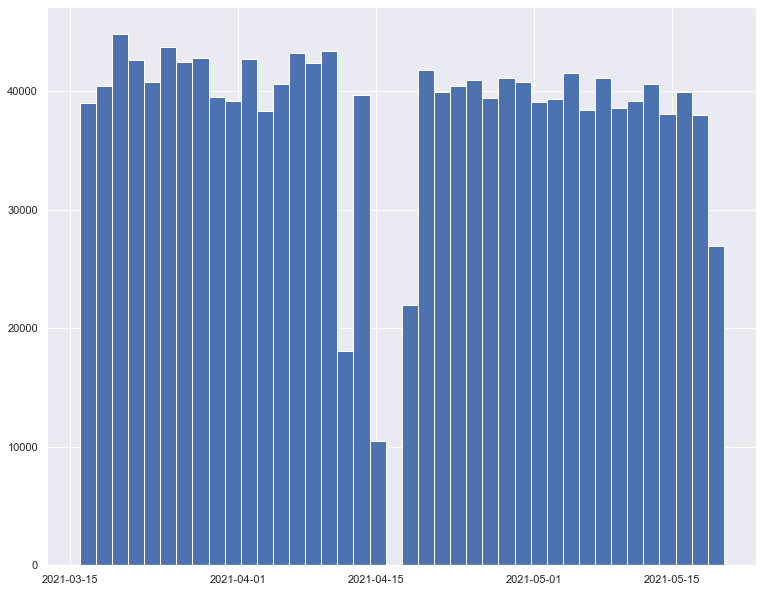

In [15]:
ndf.operation_date.hist(bins=40)

<AxesSubplot:>

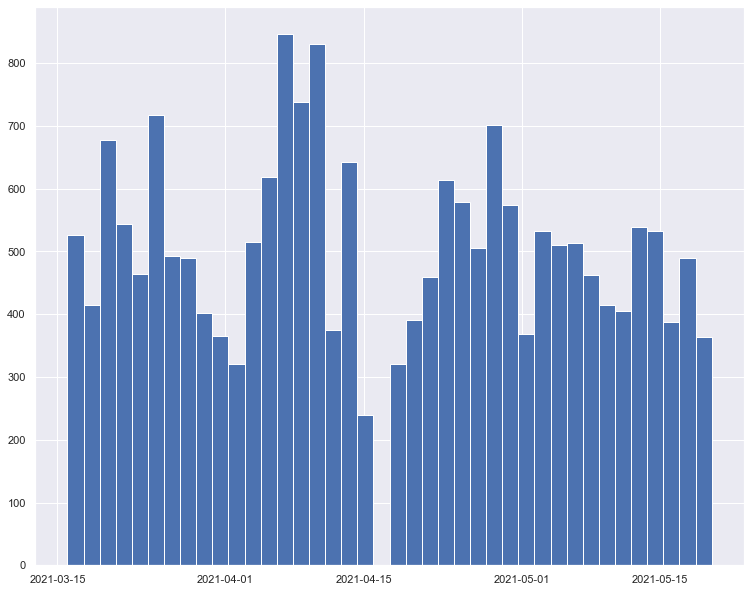

In [16]:
ndf.operation_date[ndf.operation_st_esr == st_id].hist(bins=40)

In [17]:
print(f'Размерность датасета: {ndf.shape}\n')
print(f'Временной диапазон:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}\n')

print(f'Уникальных станций: {ndf.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {ndf.car_number.nunique()}\n')

print(f'Количество вагонов которые были отправлены хотя бы один раз:\
 {ndf.car_number[ndf.operation_car == 2].nunique()}')
print(f'В датасете нет данных об отправке\
 {ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} уникальных вагонов\n')

# print('Количество операций с вагонами без станции:')
# ol = []
# for op in list(ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index):
#     ol.append(car_ops[car_ops.index_code == op].values[0][1]) 

# print(pd.DataFrame(
#     {'Шифр': ol,
#      'Опер.': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index,
#      'Строк': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().values
#     }))

Размерность датасета: (1501134, 44)

Временной диапазон:
min: 2021-03-16 00:01:00
max: 2021-05-20 05:51:00

Уникальных станций: 141
Уникальных вагонов: 119768

Количество вагонов которые были отправлены хотя бы один раз: 95585
В датасете нет данных об отправке 24183 уникальных вагонов



In [18]:
print('Уникальных операций с вагонами в датасете:')
for i in ndf.operation_car[ndf.operation_car.notnull()].value_counts().index:
    print(i,car_ops.description[car_ops.index_code == i].values)

Уникальных операций с вагонами в датасете:
4 ['ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
3 ['ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
81 ['УБОРКА ВАГОНА С ПП                    ']
80 [' ПОДАЧА ВАГОНА НА ПП                  ']
2 ['ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
21 ['ВЫГРУЗКА НА ПП                        ']
8 ['ПРИБЫТИЕ ВАГОНА НА СТАНЦИЮ            ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
79 [' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
78 [' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
30 ['ЗАНЯТИЕ ПРИ СОРТ. МЕЛКИХ ОТП. И КОНТ. ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
40 ['ОСВОБ. ПРИ СОРТ.МЕЛК.ОТПРАВОК И КОНТ. ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']


In [19]:
print('Уникальных операций с поездами в датасете:')
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

Уникальных операций с поездами в датасете:
5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
1.0 ['Приб. поезда на станцию (без приема на дорогу, отделение, участок ДНЦ)']
72.0 ['Отцепка вагонов']
71.0 ['Прицепка вагонов']
51.0 ['Приб. поезда на станцию с приемом на участок ДНЦ']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
44.0 ['Подача маршрута под грузовые операции']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
11.0 ['Приб. поезда с приемом на дорогу, из-за границы или новостройки']
35.0 ['Образование соединенного поезда']


### Визуализация датасета

In [20]:
print(f'st_id == {st_id}, в датасете с этой станцией имеются записи по:\n{ndf.car_number[ndf.operation_st_esr == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_esr == st_id].shape[0]} операциям')

st_id == 950101, в датасете с этой станцией имеются записи по:
2969 вагонам и
19881 операциям


Displaing first 800 operations out of 19881:


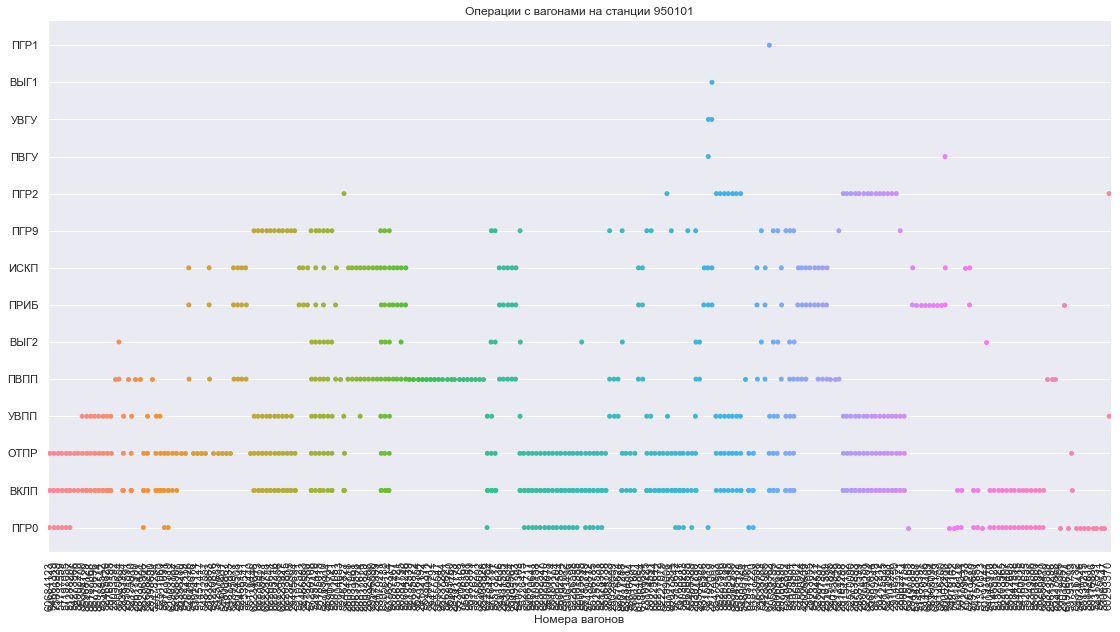

In [21]:
tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
tmp_df = tmp_df[['car_number','operation_car']]
tmp_df.car_number = tmp_df.car_number.apply(lambda x: str(x))
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

if tmp_df.shape[0] > 800:
    print(f"Displaing first 800 operations out of {tmp_df.shape[0]}:")
    tmp_df = tmp_df.loc[:800]


sns.catplot(x=tmp_df['car_number'], y=tmp_df['operation_car'],data=tmp_df,height=8, aspect=4/2)
plt.ylabel('')
plt.xlabel('Номера вагонов')
plt.xticks(rotation=90)
# plt.minorticks_on()
plt.grid(which='minor')
plt.title(f'Операции с вагонами на станции {st_id}')
plt.show()
# del(tmp_df)

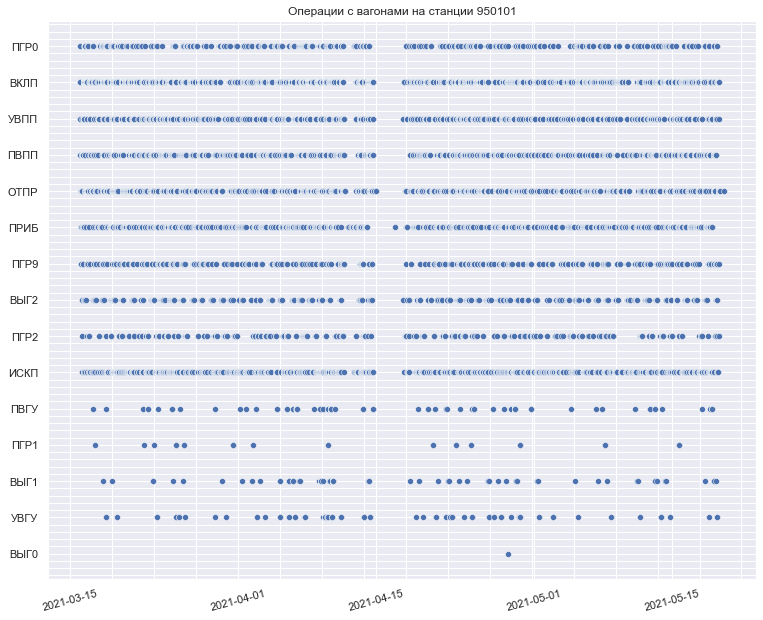

In [22]:
warnings.filterwarnings('ignore')

tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагонами на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

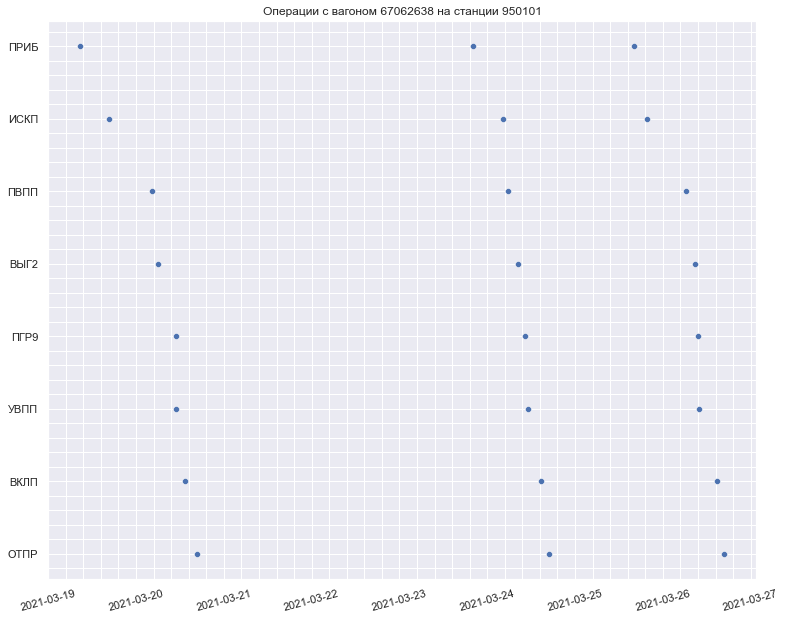

In [23]:
warnings.filterwarnings('ignore')
tmp_df = ndf[ndf.operation_st_esr == st_id][ndf.car_number == car_num].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагоном {car_num} на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

### Графы последовательностей операций

In [24]:
def ops_tr_for_set_of_carts(cartsSet: set) -> pd.DataFrame:
    """
    Builds DF with historical data of changes in states from one operation to another for a set of carts IDs.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dataframe with following format (note that state changes are not unique)
        from 	to
    0 	3 	    4
    1 	4 	    3
    2 	3 	    4
    3 	4 	    3
    ...
    """
    stateChangeDF = pd.DataFrame(columns=['from', 'to'])

    for cartID in tqdm(cartsSet):
        opsListCart = list(ndf[ndf.car_number == cartID].sort_values(by=['operation_date'])['operation_car'])
        state_change = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
        stateChangeDF = pd.concat(
            [stateChangeDF, state_change],
            axis=0,
            join="outer",
            ignore_index=True,
            keys=None,
            levels=None,
            names=None,
            verify_integrity=False,
            copy=True,
        )
    return stateChangeDF


def count_ops_transitions(cartsSet: set) -> dict:
    """
    Builds a dict with unique operation changes and state change frequency.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dict with unique operations and their quantity. See example below:
    {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
    sChangeDF = ops_tr_for_set_of_carts(cartsSet)
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

100%|██████████| 1/1 [00:00<00:00, 69.98it/s]


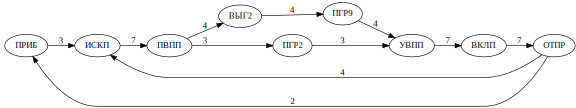

In [25]:
""" Примеры наборов номеров вагонов для графов. """

# анализ по одному вагону
carSet = {car_num}

# aнализ по всем вагонам
# carSet = set(ndf.car_number)

# анализ по станциям stations
# option A - Показать все цепочки операций по станции
# carSet = set(ndf.car_number[ndf.operation_st_id == st_id])

# option B - выбрать только цепочки длиннее заданного числа
# st = ndf.car_number[ndf.operation_st_id == st_id].value_counts()
# carSet = set(st[st > 2].index)

#####################################

sdict = count_ops_transitions(carSet)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

DG

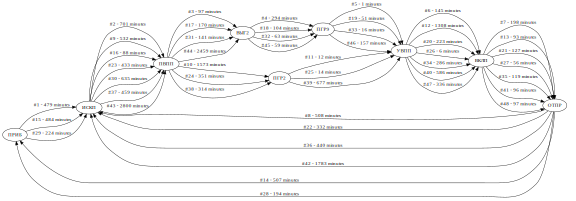

In [26]:
# построить граф переходов между операциями по вагону
# timedelta64[m] - в минутах
# timedelta64[h] - в часах

cops = ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])['operation_car'].index
DG = Digraph(f'FSM for car #{car_num}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[m]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


# DG.view() # выгрузить в pdf
DG # отобразить граф в ячейке

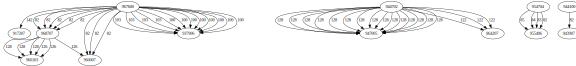

In [27]:
DG = Digraph(f'Top 50 stations interactions', filename='top_stations')
DG.attr(rankdir='TB', size='8,5')

c = ndf.index_train[ndf.operation_car == 2].value_counts()

for i in range(50):
    src = str(c.index[i])[:6]
    dst = str(c.index[i])[9:-2]
    DG.edge(src, dst,label=f'{c.values[i]}')

DG

### Анализ цепочек операций

In [28]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_esr == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_esr == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

def sort_dict(dct: dict) -> dict:
    '''
    Сортирует цепочки операций
    '''
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

In [29]:
def agg_by_car(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [30]:
cars_ops = sort_dict(extract_ops_chains(st_id))
cars_ops

100%|██████████| 2969/2969 [00:19<00:00, 152.10it/s]


{30828016: '81 80',
 42146944: '81 80',
 43688530: '81 80',
 62233952: '81 18  4  4  2',
 67789362: '81 10  4  4  2',
 52511060: '81  4  4  4  2 11 81  4  4  2  8  3 80',
 52478294: '81  4  4  4  2',
 29393394: '81  4  4  4  2',
 52135910: '81  4  4  4  2',
 52465820: '81  4  4  4  2',
 95187068: '81  4  4  2  8  3 80 11 81  4  4  4  2',
 95388542: '81  4  4  2  8  3 19 81  8  3 80 11 81',
 95392700: '81  4  4  2  8  3 19 81  4  2',
 95968129: '81  4  4  2  8  3 11 81  4  4  2',
 95972774: '81  4  4  2  8  3',
 95719696: '81  4  4  2  8  3',
 29765195: '81  4  4  2',
 29007754: '81  4  4  2',
 54822101: '81  4  4  2',
 29755394: '81  4  2  8  3 80 11 81  4  4  2',
 52608247: '81  4  2  8  3 11 81  4  2',
 80014095: '81  4  2',
 52674066: '81  4',
 42135541: '81',
 42145052: '81',
 44131431: '81',
 44402014: '81',
 52628922: '81',
 29233194: '81',
 29243391: '81',
 52391018: '81',
 52112240: '81',
 29059193: '81',
 30884209: '81',
 52451895: '80 81 80 11 81  4  4  2',
 29015948: '80 81 

In [30]:
agg_by_car(cars_ops)

{'81 80': [30828016, 42146944, 43688530],
 '81 18  4  4  2': [62233952],
 '81 10  4  4  2': [67789362],
 '81  4  4  4  2 11 81  4  4  2  8  3 80': [52511060],
 '81  4  4  4  2': [52478294, 29393394, 52135910, 52465820],
 '81  4  4  2  8  3 80 11 81  4  4  4  2': [95187068],
 '81  4  4  2  8  3 19 81  8  3 80 11 81': [95388542],
 '81  4  4  2  8  3 19 81  4  2': [95392700],
 '81  4  4  2  8  3 11 81  4  4  2': [95968129],
 '81  4  4  2  8  3': [95972774, 95719696],
 '81  4  4  2': [29765195, 29007754, 54822101],
 '81  4  2  8  3 80 11 81  4  4  2': [29755394],
 '81  4  2  8  3 11 81  4  2': [52608247],
 '81  4  2': [80014095],
 '81  4': [52674066],
 '81': [42135541,
  42145052,
  44131431,
  44402014,
  52628922,
  29233194,
  29243391,
  52391018,
  52112240,
  29059193,
  30884209],
 '80 81 80 11 81  4  4  2': [52451895, 29015948, 52469491],
 '80 81 80 11 81  4  2': [29617990],
 '80 81 80 11 81  4': [52676624],
 '80 81 18  4  2  8  3 80 11 81  4  2': [52130234],
 '80 81 10  4  4  4  2

In [31]:
# подсчет цепочек операций совпадающих по вагонам
ocl = agg_by_car(cars_ops)
for key in ocl:
    ocl[key] = len(ocl[key])
ocl = sort_dict(ocl)
ocl

{'18  4  2': 347,
 '8  3 80 21 19 81  4  2': 196,
 '8  3 80 11 81  4  4  2': 165,
 '18  4  4  2': 162,
 '8  3 80 21 19 81  4  4  2': 161,
 '8  3 78 20 18 79  4  2': 114,
 '8  3 80 11 81  4  2': 88,
 '8  3 80': 74,
 '8 3': 59,
 '4': 58,
 '8  3 78 20 18 79  4  4  2': 57,
 '11 81  4  4  2': 47,
 '80 11 81  4  4  2': 42,
 '8  3 80 21 19 81  4  4  4  2': 37,
 '8  3 78 20 18': 35,
 '8  3 80 21 19 81': 33,
 '18  4': 33,
 '8  3 80 11 81  4  4  4  2': 30,
 '79  4  4  4  2': 29,
 '8  3 80 21 19 81  4  2  8  3 80 21 19 81  4  2': 28,
 '80 21 19 81  4  4  2': 27,
 '8  3 80 19 81  4  2': 27,
 '4 2': 26,
 '8  3 80 11 81  4': 24,
 '18': 23,
 '4 4 2': 22,
 '8  3 80 21': 21,
 '3 80 11 81  4  4  2': 21,
 '8  3 78 20': 16,
 '18  4  4  4  2': 16,
 '80 21 19 81  4  2': 15,
 '80 11 81  4  2': 15,
 '21 19 81  4  4  2': 15,
 '8  3 11 81  4  4  2': 14,
 '19 81  4  4  2': 14,
 '8  3 18  4  4  2': 13,
 '18  4  4  4  4  2': 13,
 '8  3 80 81 10  4  2': 12,
 '8  3 78 20 79  4  4  2': 12,
 '3 80 21 19 81  4  2': 12,

In [32]:
# цепочка операций для вагона car_num
# ops = list(ndf.operation_car[ndf.car_number == car_num].values)

ops = list(ocl.keys())[0]
ops = list(map(float, ops.split()))
print(f'Самая повторяющаяся цепочка операций на станции {st_id}:\n{ops}')

Самая повторяющаяся цепочка операций на станции 950101:
[18.0, 4.0, 2.0]


In [33]:
# описание цепочки операций ops
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']


### Формирование датасета

In [157]:
tst = ndf[ndf.operation_date < '2021-03-16 23:59:59']
tst = tst[tst.operation_date > '2021-03-15 23:59:59']

In [56]:
'''
21 ['ВЫГРУЗКА НА ПП                        ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']
'''
ops = [21, 19, 11, 18, 20, 10, 28, 29]

In [57]:
all_cars = ndf.car_number.unique()

In [58]:
cars = tst.car_number.unique()

#### Вариант №1 - предсказание следующей операции по вагону

In [158]:
def build_df_for_train(df,ops):

    ## выбрать индексы нужных операций
    ops_index = pd.core.indexes.numeric.Int64Index([],dtype='int64')
    for op in ops:        
        ops_index = ops_index.append(df[df.operation_car == op].index)
    
    ## по индексам формируем словари с фичами
    ops_dict,times_dict,future_dict = dict.fromkeys(ops_index),dict.fromkeys(ops_index),dict.fromkeys(ops_index)
    for index in tqdm(ops_index):

        car_num = df.car_number[df.index == index].values[0]
        time_op = df.operation_date[df.index == index].values[0]

        temp_df = df[df.car_number == car_num].copy()
#         temp_df.operation_car = temp_df.operation_car.fillna(2)
        
        temp_df = temp_df.sort_values(by=['operation_date'])
        
        temp_df_future = temp_df[temp_df.operation_date > time_op]
        
        
        try:
            f1 = temp_df_future.operation_car.values[0]
            f2 = temp_df_future.operation_date.values[0] - time_op
            
        except:
            f1 = np.nan
            f2 = np.datetime64('')

        future = [f1,f2.astype('timedelta64[m]')]
        
        temp_df_past = temp_df[temp_df.operation_date <= time_op]
        temp_df_past = temp_df_past.drop(index,axis='index')

        times_list = time_op - temp_df_past.operation_date[-4:].iloc[::-1].values
        ops_list = temp_df_past.operation_car[-4:].iloc[::-1].values

        # to flip indexes .iloc[::-1]

        future_dict[index] = future
        times_dict[index] = times_list
        ops_dict[index] = ops_list
    
    ## конвертируем словари в pandas df
    df1 = pd.DataFrame.from_dict(times_dict,orient='index',columns=['minus1_timedelta','minus2_timedelta','minus3_timedelta','minus4_timedelta'])
    df2 = pd.DataFrame.from_dict(ops_dict,orient='index',columns=['minus1_op','minus2_op','minus3_op','minus4_op'])
    df3 = pd.DataFrame.from_dict(future_dict,orient='index',columns=['future_op','future_op_timedelta'])
    
    return pd.concat([df3,df.loc[ops_index],df2, df1], axis=1)

In [173]:
## посторить датасет zzz из датасета tst по списку операций ops
zzz = build_df_for_train(tst,[4])
zzz

100%|██████████| 3528/3528 [00:13<00:00, 257.81it/s]


,future_op,future_op_timedelta,adm,car_number,danger,destination_esr,destination_id,group_car,gruz,id,index_train,innovag,int_disl,kds,kod_group,length,loaded,lves,number_train,ont_time_write,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,operator,park,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,stkgos_id,tare_weight,track,train_id,uns,weight,weight_brutto,weight_netto,following_mark,processing_road,junction,special_mark_1,dispatch_id,minus1_op,minus2_op,minus3_op,minus4_op,minus1_timedelta,minus2_timedelta,minus3_timedelta,minus4_timedelta
12005,2.00,0 days 06:52:00,20,64338973,NaN,967808.00,2000038604.00,NaN,161170.00,2320791743479,960007829967600.00,1.00,0,2,NaN,1.00,1,NaN,2422.00,2021-03-17 09:05:59.918,4,2021-03-16 00:13:00,960007,2000038358,5.00,68398528,0.00,1126163.00,60,10.00,0.00,960007.00,2000038358.00,NaN,236,0.00,720798100518.00,796950716,NaN,5220.00,3762.00,0,96,NaN,0.00,2096ЭЦ865016,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
12606,2.00,0 days 06:52:00,20,64482052,NaN,967808.00,2000038604.00,NaN,161170.00,2320791746913,960007829967600.00,1.00,0,2,NaN,1.00,1,NaN,2422.00,2021-03-17 09:06:00.919,4,2021-03-16 00:13:00,960007,2000038358,5.00,68398528,0.00,1126163.00,60,10.00,0.00,960007.00,2000038358.00,NaN,246,0.00,720798100518.00,796950716,NaN,5220.00,3762.00,0,96,NaN,0.00,2096ЭЦ864827,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
9640,2.00,0 days 06:52:00,20,62795240,NaN,967808.00,2000038604.00,NaN,161170.00,2320791716228,960007829967600.00,1.00,0,2,NaN,1.00,1,NaN,2422.00,2021-03-17 09:05:52.459,4,2021-03-16 00:13:00,960007,2000038358,5.00,68398528,0.00,1126163.00,60,10.00,0.00,960007.00,2000038358.00,NaN,241,0.00,720798100518.00,796950716,NaN,5220.00,3762.00,0,96,NaN,0.00,2096ЭЦ865017,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
10164,2.00,0 days 06:52:00,20,63224612,NaN,967808.00,2000038604.00,NaN,161170.00,2320791726215,960007829967600.00,1.00,0,2,NaN,1.00,1,NaN,2422.00,2021-03-17 09:05:55.917,4,2021-03-16 00:13:00,960007,2000038358,5.00,68398528,0.00,1126163.00,60,10.00,0.00,960007.00,2000038358.00,NaN,245,0.00,720798100518.00,796950716,NaN,5220.00,3762.00,0,96,NaN,0.00,2096ЭЦ864886,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
7496,2.00,0 days 06:52:00,20,61818902,NaN,967808.00,2000038604.00,NaN,161170.00,2320791696167,960007829967600.00,1.00,0,2,NaN,1.00,1,NaN,2422.00,2021-03-17 09:05:47.915,4,2021-03-16 00:13:00,960007,2000038358,5.00,68398528,0.00,1126163.00,60,10.00,0.00,960007.00,2000038358.00,NaN,246,0.00,720798100518.00,796950716,NaN,5220.00,3762.00,0,96,NaN,0.00,2096ЭЦ864880,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40211,NaN,NaT,20,55353023,NaN,955406.00,2000038302.00,NaN,161096.00,2320795205521,951706945950101.00,NaN,0,9,NaN,1.00,2,NaN,4434.00,2021-03-18 09:05:37.083,4,2021-03-16 23:51:00,953701,2000038244,71.00,58693261,1.00,57615980.00,60,72.00,56738657.00,950101.00,2000038028.00,NaN,233,5.00,720798080788.00,798448452,NaN,239.00,0.00,0,94,NaN,3.00,2094ЭЦ895544,81.00,19.00,21.00,NaN,0 days 02:26:00,0 days 02:27:00,0 days 16:35:00,NaT
39197,NaN,NaT,20,55294516,NaN,955406.00,2000038302.00,NaN,161096.00,2320795204441,951706945950101.00,NaN,0,9,NaN,1.00,2,NaN,4434.00,2021-03-18 09:05:37.083,4,2021-03-16 23:51:00,953701,2000038244,71.00,56738657,1.00,57615980.00,60,72.00,56738657.00,950101.00,2000038028.00,NaN,237,5.00,720798080788.00,798448452,NaN,239.00,0.00,0,94,NaN,3.00,2094ЭЦ895544,81.00,19.00,21.00,NaN,0 days 02:26:00,0 days 02:27:00,0 days 16:35:00,NaT
39620,NaN,NaT,20,54875810,NaN,955406.00,2000038302.00,NaN,161096.00,2320795198186,951706945950101.00,NaN,0,9,NaN,1.00,2,NaN,4434.00,2021-03-18 09:05:35.083,4,2021-03-16 23:51:00,953701,2000038244,71.00,29890641,1.00,57615980.00,60,72.00,56738657.00,950101.00,2000038028.00,NaN,241,5.00,720798080788.00,798448452,NaN,239.00,0.00,0,94,NaN,3.00,2094

#### Вариант №2 - предсказание количества "правильных" цепочек операций

In [162]:
def get_list_of_indexes_with_success(ndf, cars, ops):
    x = []

    for car in tqdm(cars):
#         print(f'\n\t{car}')

        ops_with_car_df = ndf[ndf.car_number == car].sort_values(by=['operation_date'])['operation_car']

        for cycle, i in enumerate(ops_with_car_df.index):
#             print(ndf.loc[i]['operation_car'])  ## for debug
            if ndf.loc[i]['operation_car'] in ops:
                load_unload = ndf.loc[i]['operation_st_esr']
            if ndf.loc[i]['operation_car'] == 2:
                if ndf.loc[ops_with_car_df.index[cycle - 1]]['operation_car'] == 4:
                    if load_unload == ndf.loc[i]['operation_st_esr']:
#                         print(ndf.loc[i]['index_train'])
#                         print(ndf.loc[i]['operation_date'])   
#                         print(ndf.loc[ops_with_car_df.index[cycle - 1]]['operation_date'])
#                         print('reset load state')
                        x.append(i)
                        load_unload = False
                else:
#                     print('reset load state')
                    load_unload = False
        
    return x
            

In [163]:
x = get_list_of_indexes_with_success(tst, tst.car_number.unique(), ops)

100%|██████████| 9391/9391 [00:23<00:00, 405.85it/s]


In [188]:
# выбираем датасет только с вагонами из cars
# dff = ndf[ndf.car_number.isin(cars)]

In [164]:
# новый столбец в с таргетом
dff = tst.assign(target=pd.Series(dtype=int))

In [165]:
# помечаем все найденные индексы 
dff['target'].loc[x] = 1

<AxesSubplot:>

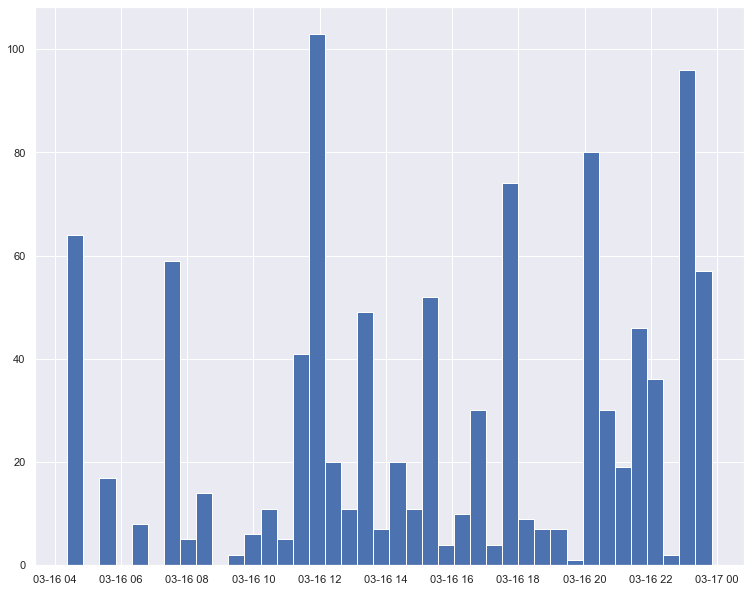

In [166]:
dff.operation_date[dff.target == 1].hist(bins=40)

In [237]:
dff[dff.target == 1]

,adm,car_number,danger,destination_esr,destination_id,group_car,gruz,id,index_train,innovag,int_disl,kds,kod_group,length,loaded,lves,number_train,ont_time_write,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,operator,park,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,stkgos_id,tare_weight,track,train_id,uns,weight,weight_brutto,weight_netto,following_mark,processing_road,junction,special_mark_1,dispatch_id,target
15360,20,56182355,NaN,944609.00,2000037808.00,0.00,161096.00,2320791791073,944007360944609.00,NaN,0,200,0.00,1.00,2,NaN,2704.00,2021-03-17 09:06:12.921,2,2021-03-16 04:23:00,944007,2000037796,2.00,0,1.00,164517.00,60,10.00,46441703.00,944609.00,2000037808.00,NaN,238,6.00,720798175734.00,797201003,0.00,1452.00,0.00,0,94,0.00,0.00,2094ЭЦ815651,1.00
15356,20,58589409,NaN,944609.00,2000037808.00,0.00,161096.00,2320791791077,944007360944609.00,NaN,0,200,0.00,1.00,2,NaN,2704.00,2021-03-17 09:06:12.921,2,2021-03-16 04:23:00,944007,2000037796,2.00,93286199,1.00,164517.00,60,10.00,46441703.00,944609.00,2000037808.00,NaN,230,6.00,720798175734.00,797201003,0.00,1452.00,0.00,0,94,0.00,0.00,2094ЭЦ815651,1.00
15371,20,56983612,NaN,944609.00,2000037808.00,0.00,161096.00,2320791791075,944007360944609.00,NaN,0,200,0.00,1.00,2,NaN,2704.00,2021-03-17 09:06:12.921,2,2021-03-16 04:23:00,944007,2000037796,2.00,42767684,1.00,164517.00,60,10.00,46441703.00,944609.00,2000037808.00,NaN,240,6.00,720798175734.00,797201003,0.00,1452.00,0.00,0,94,0.00,0.00,2094ЭЦ815651,1.00
15370,20,61792941,NaN,944609.00,2000037808.00,0.00,161096.00,2320791791087,944007360944609.00,1.00,0,200,0.00,1.00,2,NaN,2704.00,2021-03-17 09:06:12.921,2,2021-03-16 04:23:00,944007,2000037796,2.00,29890641,1.00,164517.00,60,10.00,46441703.00,944609.00,2000037808.00,NaN,244,6.00,720798175734.00,797201003,0.00,1452.00,0.00,0,94,0.00,0.00,2094ЭЦ815651,1.00
15361,20,54903224,NaN,944609.00,2000037808.00,0.00,161096.00,2320791791072,944007360944609.00,NaN,0,200,0.00,1.00,2,NaN,2704.00,2021-03-17 09:06:12.921,2,2021-03-16 04:23:00,944007,2000037796,2.00,18853482,1.00,164517.00,60,10.00,46441703.00,944609.00,2000037808.00,NaN,235,6.00,720798175734.00,797201003,0.00,1452.00,0.00,0,94,0.00,0.00,2094ЭЦ815651,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30577,26,57519894,NaN,932207.00,2000037064.00,0.00,421034.00,2320795362891,941704838941600.00,NaN,0,200,0.00,0.86,2,NaN,3586.00,2021-03-18 09:06:19.845,2,2021-03-16 23:50:00,941704,2000037662,2.00,0,1.00,48134187.00,70,40.00,15199450.00,941704.00,2000037662.00,NaN,259,6.00,720798698513.00,798561830,0.00,2681.00,1919.00,0,94,0.00,0.00,2094ЭЦ934124,1.00
30581,20,55015523,NaN,942105.00,2000037674.00,0.00,161096.00,2320795362887,941704838941600.00,NaN,0,200,0.00,1.00,1,NaN,3586.00,2021-03-18 09:06:19.845,2,2021-03-16 23:50:00,941704,2000037662,2.00,91398758,1.00,74421763.00,60,40.00,164517.00,941704.00,2000037662.00,NaN,223,6.00,720798698513.00,798561830,71000.00,2681.00,1919.00,0,94,0.00,0.00,2094ЭЦ929377,1.00
30576,20,51671311,NaN,932207.00,2000037064.00,0.00,421034.00,2320795362884,941704838941600.00,NaN,0,200,0.00,0.86,2,NaN,3586.00,2021-03-18 09:06:19.845,2,2021-03-16 23:50:00,941704,2000037662,2.00,15199450,1.00,48134187.00,70,40.00,15199450.00,941704.00,2000037662.00,NaN,260,6.00,720798698513.00,798561830,0.00,2681.00,1919.00,0,94,0.00,0.00,2094ЭЦ934124,1.00
30586,20,68274315,NaN,942105.00,2000037674.00,0.00,161096.00,2320795362910,941704838941600.00,NaN,0,200,0.00,1.00,1,NaN,3586.00,2021-03-18 09:06:19.845,2,2021-03-16 23:50:00,941704,2000037662,2.00,52682351,1.00,74421763.00,60,40.00,164517.00,941704.00,2000037662.00,NaN,230,6.00,720798698513.00,798561830,76980.00,2681.00,1919.00,0,94,0.00,0.00,2094ЭЦ929377,1.00


In [51]:
# dff.to_csv('some_df_with_target.csv',sep=';',index_label='original_index')

In [73]:
l = pd.read_csv('df_with_target.csv',sep=';', index_col='original_index',parse_dates=['operation_date','ont_time_write'])

In [194]:
dff.index_train[dff.target == 1].value_counts()

pandas.core.series.Series

In [232]:
def count_cars(dff):
    pairs = {}
    counts = dff.index_train[dff.target == 1].value_counts()
    for count in counts.index: 
        src = str(int(count // 1e9))
        dst = str(int(count % 1e6))
        entry = src +'->'+dst 
        if entry in pairs:
            pairs[entry] += counts[count]
        else:
            pairs[entry] = counts[count]
    return pairs

In [256]:
tdf1 = pd.DataFrame.from_dict(count_cars(dff),orient='index',columns=['count'])

In [290]:
tm = dff.operation_date.min() + pd.Timedelta(4,unit="hours")

dff.target[dff.operation_date < tm][dff.target ==1].count()

0

In [306]:
tm_from = dff.operation_date.min()

while tm_from < dff.operation_date.max():
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    print(tdf.head())

Empty DataFrame
Columns: [2021-03-16 04:01:00]
Index: []
                2021-03-16 08:01:00
944007->944609                   60
954704->950101                   59
968707->960103                   17
960007->970001                    5
930004->960007                    4
                2021-03-16 12:01:00
942105->944609                   77
954704->950101                   20
966504->967600                   13
963402->962804                   10
953504->953701                    9
                2021-03-16 16:01:00
944609->944007                   42
941704->941600                   26
960007->917207                   20
940006->940105                   16
968707->960103                   12
                2021-03-16 20:01:00
955406->954704                   46
968209->967600                   39
968707->960103                   28
950101->955406                   19
954704->950101                    8
                2021-03-17 00:01:00
944007->944609                   61
944609-

In [307]:
tdf

,2021-03-17 00:01:00
944007->944609,61
944609->944007,42
941704->941600,32
954704->950101,31
960007->967600,20
950101->951706,20
944609->943108,15
963402->962804,15
962804->961407,14
940105->940006,11


In [280]:
ay = dff.target
# ay = ay.fillna(0)
ax = dff.operation_date

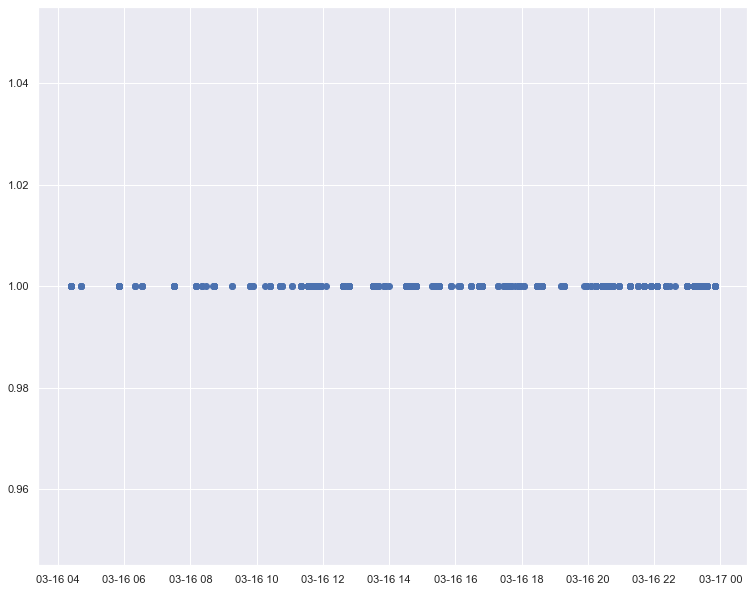

In [281]:
plt.scatter(x=ax,y=ay)

### Drafts

In [206]:
## profiler code
dt = datetime.datetime.now().strftime("%m/%d/%y - %H:%M")
profile = ProfileReport(dff, title=dt, explorative=True)
profile
fname = 'zzz-report.html'
profile.to_file(output_file=fname)